In [358]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopy.distance as gd

from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from shapely.geometry import Point, Polygon
from scipy.optimize import minimize
from networkx.algorithms.flow import *

import cvxpy as cp
from utils import *

In [236]:
!pip3 install cvxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.1/882.1 kB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.2/252.2 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.2 MB/s eta 0:00:00


In [30]:
df = pd.read_csv("teams.csv")

In [31]:
print(df.style.to_latex())

\begin{tabular}{lllllrr}
 & team_name & city_name & conference & division & arena_lat & arena_long \\
0 & Boston Celtics & Boston, MA & eastern & atlantic & -71.062228 & 42.366303 \\
1 & Brooklyn Nets & New York City, NY & eastern & atlantic & -73.974689 & 40.682650 \\
2 & New York Knicks & New York City, NY & eastern & atlantic & -73.993611 & 40.750556 \\
3 & Philadelphia 76ers & Philadelphia, PA & eastern & atlantic & -75.171944 & 39.901111 \\
4 & Toronto Raptors & Toronto, Ontario & eastern & atlantic & -79.379167 & 43.643333 \\
5 & Chicago Bulls & Chicago, IL & eastern & central & -87.674167 & 41.880556 \\
6 & Cleveland Cavaliers & Cleveland, OH & eastern & central & -81.688056 & 41.496389 \\
7 & Detroit Pistons & Detroit, MI & eastern & central & -83.245556 & 42.696944 \\
8 & Indiana Pacers & Indianapolis, IN & eastern & central & -86.155556 & 39.763889 \\
9 & Milwaukee Bucks & Milwaukee, WI & eastern & central & -87.916944 & 43.043611 \\
10 & Atlanta Hawks & Atlanta, GA & eastern

In [32]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.arena_lat, df.arena_long), crs="EPSG:4326")

In [33]:
gdf

,team_name,city_name,conference,division,arena_lat,arena_long,geometry
0,Boston Celtics,"Boston, MA",eastern,atlantic,-71.062228,42.366303,POINT (-71.06223 42.36630)
1,Brooklyn Nets,"New York City, NY",eastern,atlantic,-73.974689,40.682650,POINT (-73.97469 40.68265)
2,New York Knicks,"New York City, NY",eastern,atlantic,-73.993611,40.750556,POINT (-73.99361 40.75056)
3,Philadelphia 76ers,"Philadelphia, PA",eastern,atlantic,-75.171944,39.901111,POINT (-75.17194 39.90111)
4,Toronto Raptors,"Toronto, Ontario",eastern,atlantic,-79.379167,43.643333,POINT (-79.37917 43.64333)
5,Chicago Bulls,"Chicago, IL",eastern,central,-87.674167,41.880556,POINT (-87.67417 41.88056)
6,Cleveland Cavaliers,"Cleveland, OH",eastern,central,-81.688056,41.496389,POINT (-81.68806 41.49639)
7,Detroit Pistons,"Detroit, MI",eastern,central,-83.245556,42.696944,POINT (-83.24556 42.69694)
8,Indiana Pacers,"Indianapolis, IN",eastern,central,-86.155556,39.763889,POINT (-86.15556 39.76389)
9,Milwaukee Bucks,"Milwaukee, WI",eastern,central,-87.916944,43.043611,POINT (-87.91694 43.04361)


In [34]:
print(gdf.style.to_latex())

\begin{tabular}{lllllrrl}
 & team_name & city_name & conference & division & arena_lat & arena_long & geometry \\
0 & Boston Celtics & Boston, MA & eastern & atlantic & -71.062228 & 42.366303 & POINT (-71.062228 42.366303) \\
1 & Brooklyn Nets & New York City, NY & eastern & atlantic & -73.974689 & 40.682650 & POINT (-73.974689 40.68265) \\
2 & New York Knicks & New York City, NY & eastern & atlantic & -73.993611 & 40.750556 & POINT (-73.993611 40.750556) \\
3 & Philadelphia 76ers & Philadelphia, PA & eastern & atlantic & -75.171944 & 39.901111 & POINT (-75.171944 39.901111) \\
4 & Toronto Raptors & Toronto, Ontario & eastern & atlantic & -79.379167 & 43.643333 & POINT (-79.379167 43.643333) \\
5 & Chicago Bulls & Chicago, IL & eastern & central & -87.674167 & 41.880556 & POINT (-87.674167 41.880556) \\
6 & Cleveland Cavaliers & Cleveland, OH & eastern & central & -81.688056 & 41.496389 & POINT (-81.688056 41.496389) \\
7 & Detroit Pistons & Detroit, MI & eastern & central & -83.245556

In [98]:
usa = gpd.read_file("data/usa-states-census-2014.shp")
print(usa.crs)

epsg:4326


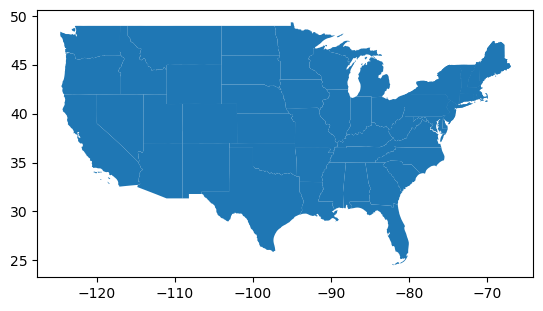

In [97]:
m = usa.plot()
#gdf.explore(m=m, color="red")

In [217]:
# Creating an adjacency matrix with the number of games as weights 

A_num_games_as_weights = np.zeros((30,30))
for i in range(len(gdf["team_name"])):
    for j in range(len(gdf["team_name"])):
        if i == j:
            A_num_games_as_weights[i][j] = 0
        elif gdf.iloc[i]["division"] == gdf.iloc[j]["division"]:
            A_num_games_as_weights[i][j] = 2
        else:
            A_num_games_as_weights[i][j] = 1
            
#print(A_num_games_as_weights)

In [88]:
# Creating an adjacency matrix with the distances as the crow flies as weights 

A_dist_as_weights = np.zeros((30,30))
for i in range(len(gdf["team_name"])):
    for j in range(len(gdf["team_name"])):
        #print(gpd.geodesic((gdf.iloc[i]["arena_long"],gdf.iloc[i]["arena_lat"]), (gdf.iloc[j]["arena_long"],gdf.iloc[j]["arena_lat"])).miles)
        if i == j:
            A_dist_as_weights[i][j] = 0
        else:
            A_dist_as_weights[i][j] = np.round(gd.geodesic((gdf.iloc[i]["arena_long"],gdf.iloc[i]["arena_lat"]), (gdf.iloc[j]["arena_long"],gdf.iloc[j]["arena_lat"])).miles)            
#print(A_dist_as_weights)

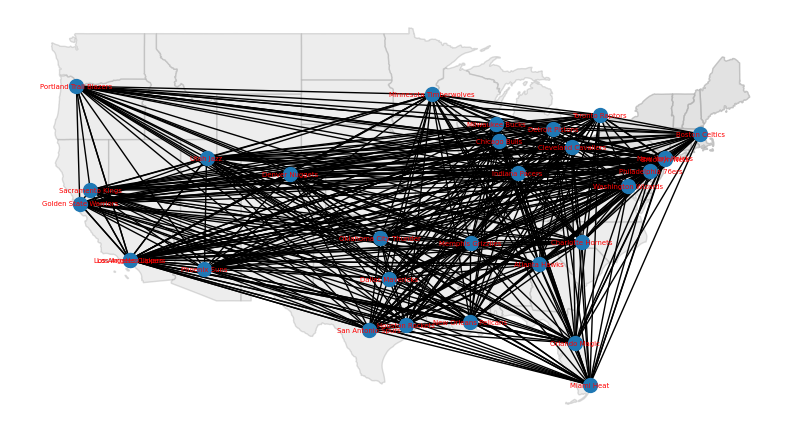

In [100]:
# Visualizing the adjacency matrix with the distances 

G_dist = nx.from_numpy_matrix(A_dist_as_weights)
G_dist = nx.relabel_nodes(G_dist, {k:v for k,v in zip(range(30), gdf["team_name"])})
xy = [list(i) for i in zip(gdf['geometry'].x, gdf['geometry'].y)]
coord = dict(zip(gdf['team_name'], xy))
pos=coord
#nx.draw_networkx(G_dist,pos)
labels = nx.get_edge_attributes(G_dist,'weight')
#nx.draw_networkx_edge_labels(G_dist,pos,edge_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
    
usa.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw(G_dist, pos=pos, with_labels=True, font_color='red', node_size=100, arrowsize=2, font_size=5)
#l = nx.draw_networkx_edge_labels(G_dist, pos, edge_labels=labels, font_color='blue', font_size=5)

In [141]:
n2v = Node2Vec(G_dist, dimensions=6, walk_length=50, num_walks=300, workers=4) 

Generating walks (CPU: 1): 100%|██████████| 75/75 [00:03<00:00, 22.90it/s]


In [142]:
model = n2v.fit(window=5, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

In [143]:
n_ids = model.wv.index_to_key 
n2v_embeddings = model.wv.vectors
#print(n_ids)
n_dict = {k:v for k,v in zip(n_ids, n2v_embeddings)}

#print(nx.get_node_attributes(G, 'osmid'))

n_df = pd.DataFrame([model.wv.get_vector(str(n)) for n in G_dist.nodes()], index = G_dist.nodes)
#print(n_df)

/Users/tiffanychen/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tiffanychen/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


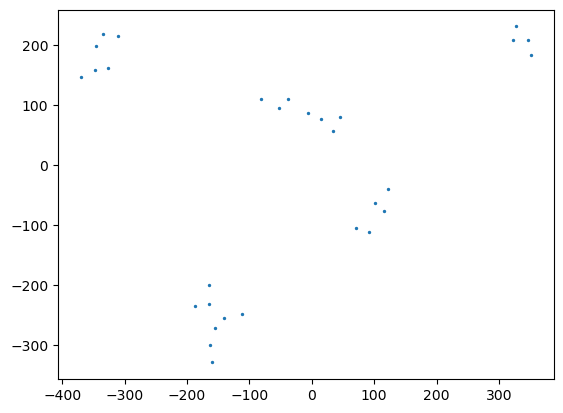

In [186]:
tsne = TSNE(n_components=2, perplexity=3)
n2v_embeddings_2d = tsne.fit_transform(n2v_embeddings)

plt.scatter(n2v_embeddings_2d[:,0], n2v_embeddings_2d[:,1], s=2)

In [163]:
kmeans = KMeans(n_clusters=6)
k_cluster = kmeans.fit_predict(n_df)

spec = SpectralClustering(n_clusters=2)
s_cluster = spec.fit(n_df).labels_

temp_dict = {n_ids[i]: j for i, j in enumerate(k_cluster)}
temp_dict2 = {n_ids[i]: j for i, j in enumerate(s_cluster)}

nx.set_node_attributes(G_dist, temp_dict, "k_cluster")
colors = [k_cluster[i] for i in range(len(G_dist.nodes()))]
nx.set_node_attributes(G_dist, temp_dict2, "s_cluster")
colors2 = [s_cluster[i] for i in range(len(G_dist.nodes()))]

In [164]:
print(colors2)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]


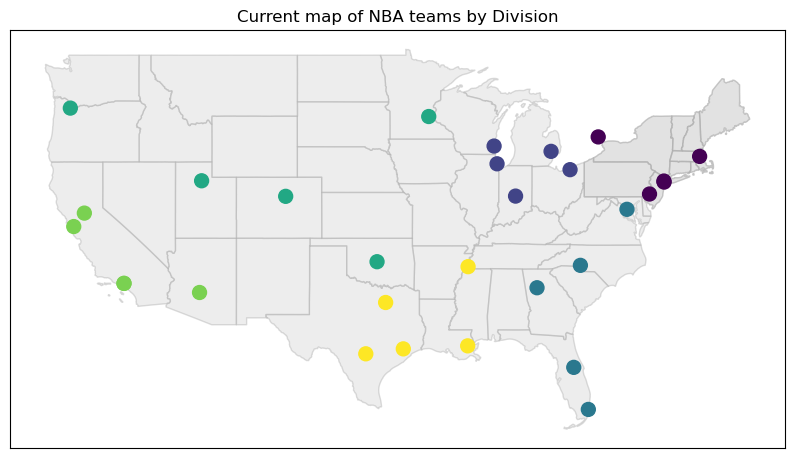

In [183]:
colors3 = []
c = 0
for i in range(30):
    if i%5 == 0:
        c += 1
    colors3.append(c)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_title('Current map of NBA teams by Division')

usa.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, pos=pos, node_size=100, node_color=colors3)

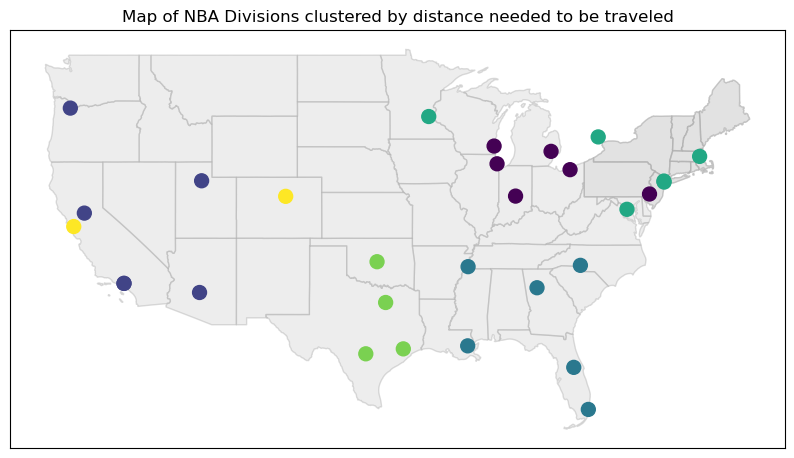

In [188]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_title('Map of NBA Divisions clustered by distance needed to be traveled')

usa.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, pos=pos, node_size=100, node_color=colors)

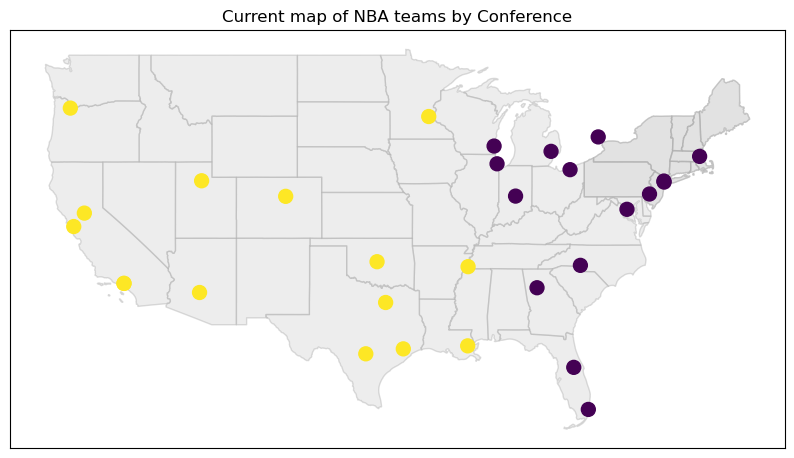

In [187]:
colors4 = []
c = 0
for i in range(30):
    if i%15 == 0:
        c += 1
    colors4.append(c)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_title('Current map of NBA teams by Conference')

usa.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, pos=pos, node_size=100, node_color=colors4)

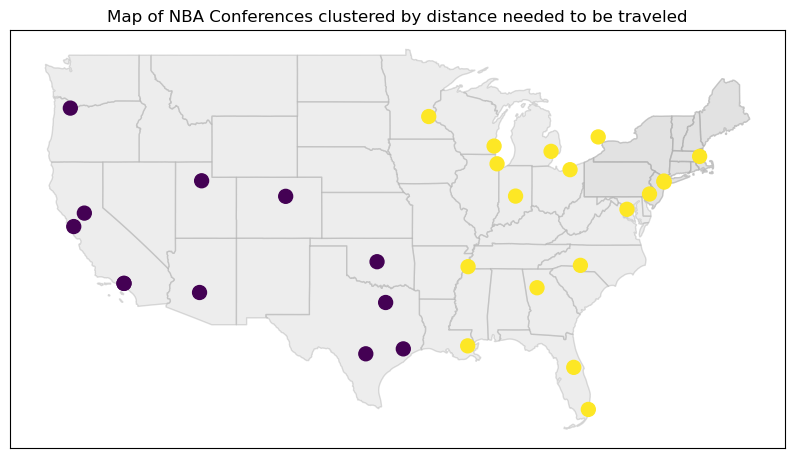

In [189]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_title('Map of NBA Conferences clustered by distance needed to be traveled')

usa.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

nx.draw_networkx_nodes(G_dist, pos=pos, node_size=100, node_color=colors2)

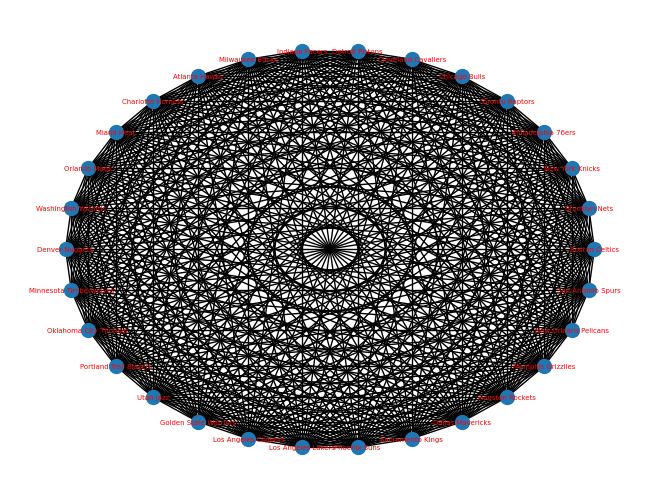

In [208]:
G_games = nx.DiGraph()
G_games = nx.from_numpy_matrix(A_num_games_as_weights)
G_games = nx.relabel_nodes(G_games, {k:v for k,v in zip(range(30), gdf["team_name"])})

pos = nx.circular_layout(G_games)
nx.draw(G_games, pos=pos, with_labels=True, font_color='red', node_size=100, arrowsize=5, font_size=5)

In [232]:
A_total_dist = A_dist_as_weights@A_num_games_as_weights
distances_home = np.diag(A_total_dist)

In [233]:
dists = {k:v for k,v in zip(G_dist.nodes, distances_home)}
print(dists["Portland Trail Blazers"])

55207.0


In [228]:
print(A_total_dist[0])

[39551. 39169. 39175. 39003. 38691. 40453. 41057. 40915. 40545. 40443.
 41016. 41448. 40380. 40660. 42102. 43956. 45248. 44504. 42418. 43298.
 45897. 46097. 46097. 46693. 46031. 42783. 42675. 43613. 43167. 42359.]


In [230]:
print(A_dist_as_weights[0])

[   0.  191.  188.  274.  430.  853.  551.  622.  807.  858.  937.  721.
 1255. 1115.  394. 1770. 1124. 1496. 2539. 2099. 2698. 2598. 2598. 2300.
 2631. 1552. 1606. 1137. 1360. 1764.]


In [231]:
print(A_num_games_as_weights[:,1])

[2. 0. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [239]:
attendance_df = pd.read_csv("attendance_data.csv")
print(attendance_df)

                 Date Start (ET)         Visitor/Neutral  PTS  \
0     Tue Oct 16 2018      8:00p      Philadelphia 76ers   87   
1     Tue Oct 16 2018     10:30p   Oklahoma City Thunder  100   
2     Wed Oct 17 2018      7:00p         Milwaukee Bucks  113   
3     Wed Oct 17 2018      7:00p           Brooklyn Nets  100   
4     Wed Oct 17 2018      7:00p       Memphis Grizzlies   83   
...               ...        ...                     ...  ...   
1225  Wed Apr 10 2019      8:00p           Chicago Bulls  109   
1226  Wed Apr 10 2019      8:00p        Dallas Mavericks   94   
1227  Wed Apr 10 2019     10:30p  Minnesota Timberwolves   95   
1228  Wed Apr 10 2019     10:30p               Utah Jazz  137   
1229  Wed Apr 10 2019     10:30p        Sacramento Kings  131   

                Home/Neutral  PTS.1 Unnamed: 6 Unnamed: 7  Attend.  \
0             Boston Celtics    105  Box Score        NaN    18624   
1      Golden State Warriors    108  Box Score        NaN    19596   
2        

In [252]:
attendance_df["Home_City"] = [gdf.loc[gdf["team_name"] == i]["city_name"].values[0] for i in attendance_df["Home/Neutral"]]

In [253]:
print(attendance_df)

                 Date Start (ET)         Visitor/Neutral  PTS  \
0     Tue Oct 16 2018      8:00p      Philadelphia 76ers   87   
1     Tue Oct 16 2018     10:30p   Oklahoma City Thunder  100   
2     Wed Oct 17 2018      7:00p         Milwaukee Bucks  113   
3     Wed Oct 17 2018      7:00p           Brooklyn Nets  100   
4     Wed Oct 17 2018      7:00p       Memphis Grizzlies   83   
...               ...        ...                     ...  ...   
1225  Wed Apr 10 2019      8:00p           Chicago Bulls  109   
1226  Wed Apr 10 2019      8:00p        Dallas Mavericks   94   
1227  Wed Apr 10 2019     10:30p  Minnesota Timberwolves   95   
1228  Wed Apr 10 2019     10:30p               Utah Jazz  137   
1229  Wed Apr 10 2019     10:30p        Sacramento Kings  131   

                Home/Neutral  PTS.1 Unnamed: 6 Unnamed: 7  Attend.  \
0             Boston Celtics    105  Box Score        NaN    18624   
1      Golden State Warriors    108  Box Score        NaN    19596   
2        

In [269]:
edge_list_data = attendance_df[["Visitor/Neutral", "Home_City", "Attend."]]

In [325]:
print(edge_list_data)
edge_list_data_agg = edge_list_data.groupby(["Visitor/Neutral", "Home_City"]).agg({"Attend.": "mean"}).reset_index()
edge_list_df = edge_list_data_agg.rename(columns={"Visitor/Neutral": "source", "Home_City": "target", "Attend.": "capacity"})
print(edge_list_df)

             Visitor/Neutral          Home_City  Attend.
0         Philadelphia 76ers         Boston, MA    18624
1      Oklahoma City Thunder  San Francisco, CA    19596
2            Milwaukee Bucks      Charlotte, NC    17889
3              Brooklyn Nets        Detroit, MI    20332
4          Memphis Grizzlies   Indianapolis, IN    17923
...                      ...                ...      ...
1225           Chicago Bulls   Philadelphia, PA    20197
1226        Dallas Mavericks    San Antonio, TX    18629
1227  Minnesota Timberwolves         Denver, CO    16332
1228               Utah Jazz    Los Angeles, CA    17655
1229        Sacramento Kings       Portland, OR    19814

[1230 rows x 3 columns]
                 source              target  capacity
0         Atlanta Hawks          Boston, MA   18624.0
1         Atlanta Hawks       Charlotte, NC   13463.0
2         Atlanta Hawks         Chicago, IL   19374.5
3         Atlanta Hawks       Cleveland, OH   19432.0
4         Atlanta Haw

In [336]:
sources = edge_list_df.groupby(['source']).mean().reset_index()
targets = edge_list_df.groupby(['target']).mean().reset_index()

/var/folders/g9/wb8l1klx5xdcj7d648gcjv0w0000gn/T/ipykernel_90246/135361481.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sources = edge_list_df.groupby(['source']).mean().reset_index()
/var/folders/g9/wb8l1klx5xdcj7d648gcjv0w0000gn/T/ipykernel_90246/135361481.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  targets = edge_list_df.groupby(['target']).mean().reset_index()


In [349]:
print(edge_list_df[edge_list_df["source"] == "Boston Celtics"])

            source              target  capacity
27  Boston Celtics         Atlanta, GA  15821.50
28  Boston Celtics       Charlotte, NC  18739.00
29  Boston Celtics         Chicago, IL  21109.00
30  Boston Celtics       Cleveland, OH  19432.00
31  Boston Celtics          Dallas, TX  20226.00
32  Boston Celtics          Denver, CO  19520.00
33  Boston Celtics         Detroit, MI  17599.00
34  Boston Celtics         Houston, TX  18055.00
35  Boston Celtics    Indianapolis, IN  17438.00
36  Boston Celtics     Los Angeles, CA  19032.50
37  Boston Celtics         Memphis, TN  17794.00
38  Boston Celtics           Miami, FL  19752.00
39  Boston Celtics       Milwaukee, WI  17926.00
40  Boston Celtics     Minneapolis, MN  17663.00
41  Boston Celtics     New Orleans, LA  15189.00
42  Boston Celtics   New York City, NY  17937.25
43  Boston Celtics   Oklahoma City, OK  18203.00
44  Boston Celtics         Orlando, FL  18846.00
45  Boston Celtics    Philadelphia, PA  20594.00
46  Boston Celtics  

In [338]:
print(sources["capacity"].values)

[17841.02777778 18592.41666667 17931.32142857 17590.16666667
 17849.76851852 17761.14197531 18091.53703704 17469.71296296
 17885.43518519 18861.35185185 17971.33333333 17676.84567901
 17332.23214286 19019.16071429 17754.93209877 18167.47222222
 18204.30555556 17739.62962963 17623.66666667 17617.125
 17853.04320988 17637.71604938 18048.16666667 17853.69444444
 17939.81481481 17200.75925926 17502.82407407 18167.15740741
 17724.33333333 17430.5462963 ]


In [339]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(edge_list_df, edge_attr=True, create_using=nx.DiGraph())

nodes = list(G.nodes)

s = 0
t = 0

for node in nodes:
    if node in edge_list_df["source"].values:
        G.add_edge('s', node, capacity=sources["capacity"][s])
        s += 1
    else:
        G.add_edge(node, 't', capacity=targets["capacity"][t])
        t += 1

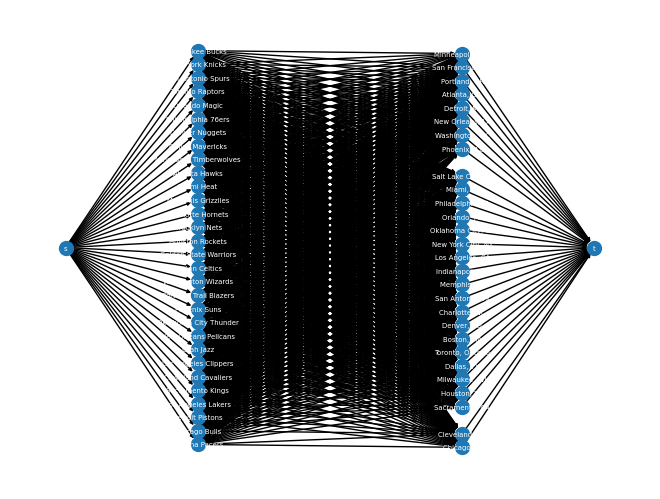

In [340]:
pos = flow_layout(G, 's', 't')
nx.draw(G, with_labels=True, font_color='white', node_size=100, arrowsize=5, font_size=5, pos=pos)

In [385]:
flow_value, flow_dict = nx.maximum_flow(G, 's', 't', capacity="capacity", flow_func=edmonds_karp)
print(flow_value)
print(flow_dict["San Antonio Spurs"])

500618.2723180078
{'Atlanta, GA': 0, 'Boston, MA': 0, 'Charlotte, NC': 0, 'Chicago, IL': 0, 'Cleveland, OH': 0, 'Dallas, TX': 0, 'Denver, CO': 0, 'Detroit, MI': 0, 'Houston, TX': 0, 'Indianapolis, IN': 0, 'Los Angeles, CA': 0, 'Memphis, TN': 0, 'Miami, FL': 0, 'Milwaukee, WI': 0, 'Minneapolis, MN': 0, 'New Orleans, LA': 0, 'New York City, NY': 0, 'Oklahoma City, OK': 0, 'Orlando, FL': 0, 'Philadelphia, PA': 0, 'Phoenix, AZ': 0, 'Portland, OR': 0, 'Sacramento, CA': 0, 'Salt Lake City, UT': 0, 'San Francisco, CA': 0, 'Toronto, Ontario': 0, 'Washington, DC': 17502.824074074073}


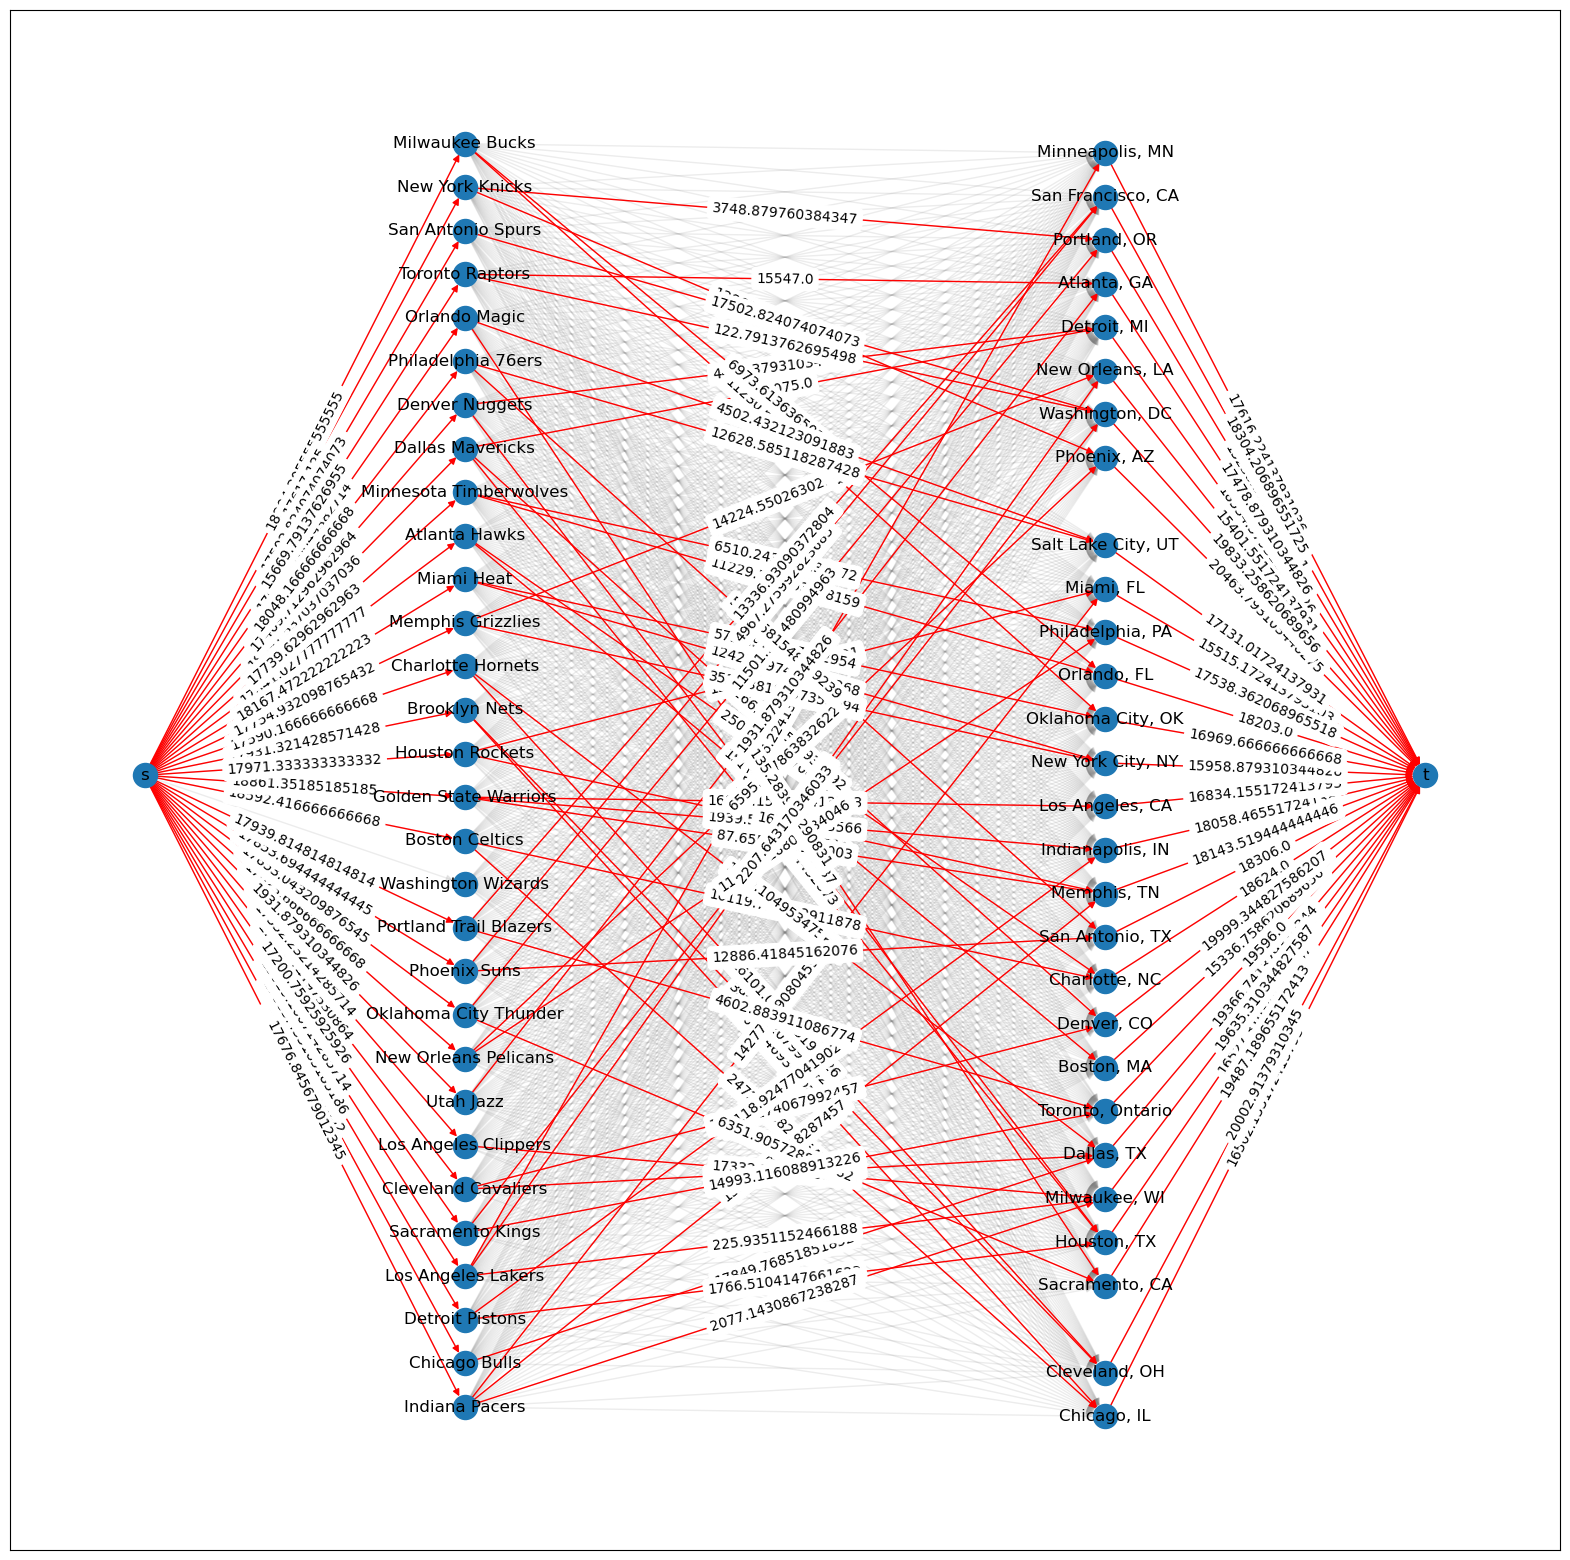

In [381]:
draw_flow(G, flowDict=flow_dict, fig_kwargs={"figsize":(20, 20)}, nx_kwargs={"font_size": 10})

In [347]:
#print(attendance_df.style.to_latex())